# YOLOv5 Instance Segmentation Tutorial
https://blog.roboflow.com/train-yolov5-instance-segmentation-custom-dataset/

YOLOv5 supports instance segmentation tasks too. This is the official YOLOv5 instance segmentation notebook tutorial. YOLOv5 is maintained by [Ultralytics](https://github.com/ultralytics/yolov5).

This notebook covers:

*   Inference with out-of-the-box YOLOv5 instance segmentation on COCO-128 Segmentatation
*  [Training YOLOv5 instance segmentation](https://blog.roboflow.com//train-yolov5-instance-segmentation-custom-dataset) on custom data

*Looking for custom data? Explore over 66M community datasets on [Roboflow Universe](https://universe.roboflow.com).*

This notebook was created with Google Colab. [Click here](https://colab.research.google.com/drive/1JTz7kpmHsg-5qwVz2d2IH3AaenI1tv0N?usp=sharing) to run it.

# Setup
Pull in respective libraries to prepare the notebook environment

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git # clone
%cd yolov5
%pip install -r requirements.txt # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.4/166.8 GB disk)


# 1. Infer on COCO-128

To demonstrate YOLOv5 instance segmentation, we'll leverage an already trained model. In this case, we'll download the COCO-128 trained models pretrained on COCO-128 using YOLOv5 Utils.

If you'd like to skip to custom trainining, jump to section 3 below.

In [ ]:
from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-seg' for x in p5]  # segmentation models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/14.9M [00:00<?, ?B/s]

  0%|          | 0.00/42.4M [00:00<?, ?B/s]

  0%|          | 0.00/91.9M [00:00<?, ?B/s]

  0%|          | 0.00/170M [00:00<?, ?B/s]

Now, we can infer on an example image from the COCO-128 dataset.

In [ ]:
#Download example image
import requests
image_url = "https://i.imgur.com/EbOBS5l.jpg"
img_data = requests.get(image_url).content
with open('zebra.jpg', 'wb') as handler:
    handler.write(img_data)

segment/predict: weights=['./weights/yolov5s-seg.pt'], source=zebra.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s-seg summary: 224 layers, 7611485 parameters, 0 gradients, 26.4 GFLOPs
image 1/1 /content/yolov5/zebra.jpg: 448x640 1 zebra, 13.7ms
Speed: 0.6ms pre-process, 13.7ms inference, 67.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/exp


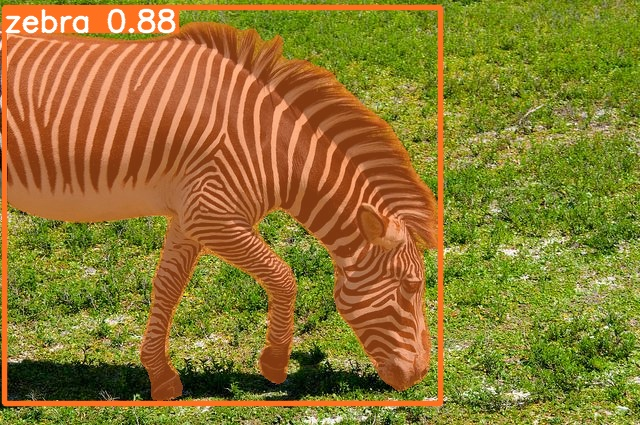

In [ ]:
#Infer using segment/predict.py
!python segment/predict.py --weights ./weights/yolov5s-seg.pt --source zebra.jpg
display.Image(filename='runs/predict-seg/exp/zebra.jpg', width=600)

## 2. (Optional) Validate

Use the `segment/val.py` script to run validation for the model. This will show us the model's performance.

First, we need to download COCO-128.

In [ ]:
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco128-seg.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../datasets && rm tmp.zip  # unzip

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

In [ ]:
!python segment/val.py --weights yolov5s-seg.pt --data coco128-seg.yaml --img 640

segment/val: data=/content/yolov5/data/coco128-seg.yaml, weights=['yolov5s-seg.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

100% 14.9M/14.9M [00:00<00:00, 252MB/s]

Fusing layers... 
YOLOv5s-seg summary: 224 layers, 7611485 parameters, 0 gradients, 26.4 GFLOPs
val: Scanning '/content/datasets/coco128-seg/labels/train2017' images and labels...126 found, 2 missing, 0 empty, 0 corrupt: 100% 128/128 [00:00<00:00, 1216.50it/s]
val: New cache created: /content/datasets/coco128-seg/labels/train2017.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 4/4 [00

The output shows performance metrics for the COCO-128 validation dataset.

# 3. Train On Custom Data

To train on custom data, we need to prepare a dataset with custom labels.

To prepare custom data, we'll use [Roboflow](https://roboflow.com). Roboflow enables easy dataset prep with your team, including labeling, formatting into the right export format, deploying, and active learning with a `pip` package. 

If you need custom data, there are over 66M open source images from the community on [Roboflow Universe](https://universe.roboflow.com).

(For more guidance, here's a detailed blog on [training YOLOv5 instance segmentation on custom data](https://blog.roboflow.com/train-yolov5-instance-segmentation-custom-dataset).)


Create a free Roboflow account, upload your data, and label. 

![](https://robflow-public-assets.s3.amazonaws.com/how-to-train-yolov5-segmentation-annotation.gif)

### Load Custom Dataset

Next, we'll export our dataset into the right directory structure for training YOLOv5 segmentation to load into this notebook. Select the `Export` button at the top of the version page, `YOLO v5 Pytorch` type, and `show download code`.

This ensures all our directories are in the right format with the needed data.yaml file:

```
dataset
├── train
│   ├── images
│   │   ├── IMG_123.jpg
│   └── labels
│       ├── IMG_123.xml
├── valid
│   ├── images
│   │   ├── IMG_456.jpg
│   └── labels
│       ├── IMG_456.xml
├── test
│   ├── images
│   │   ├── IMG_789.jpg
│   └── labels
│       ├── IMG_789.xml
├── data.yaml
├── README.roboflow.txt
```

![](https://robflow-public-assets.s3.amazonaws.com/how-to-train-yolov5-segmentation-format.gif)


Copy and paste that snippet into the cell below.

In [ ]:
# REPLACE the below with your exported code snippet from above
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR API KEY")
project = rf.workspace("paul-guerrie-tang1").project("asl-poly-instance-seg")
dataset = project.version(24).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ASL-Poly-Instance-Seg-24 in yolov5pytorch:: 100%|██████████| 3349/3349 [00:02<00:00, 1483.29it/s]


### Train On Custom Data 🎉
Here, we use the `dataset.location` attribute to pass our dataset to the `--data` parameter.

Note: we're training for 100 epochs here. We're also starting training from the pretrained weights. Larger datasets will likely benefit from longer training. 

segment/train: weights=yolov5s-seg.pt, cfg=, data=/content/yolov5/ASL-Poly-Instance-Seg-24/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=128, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.01

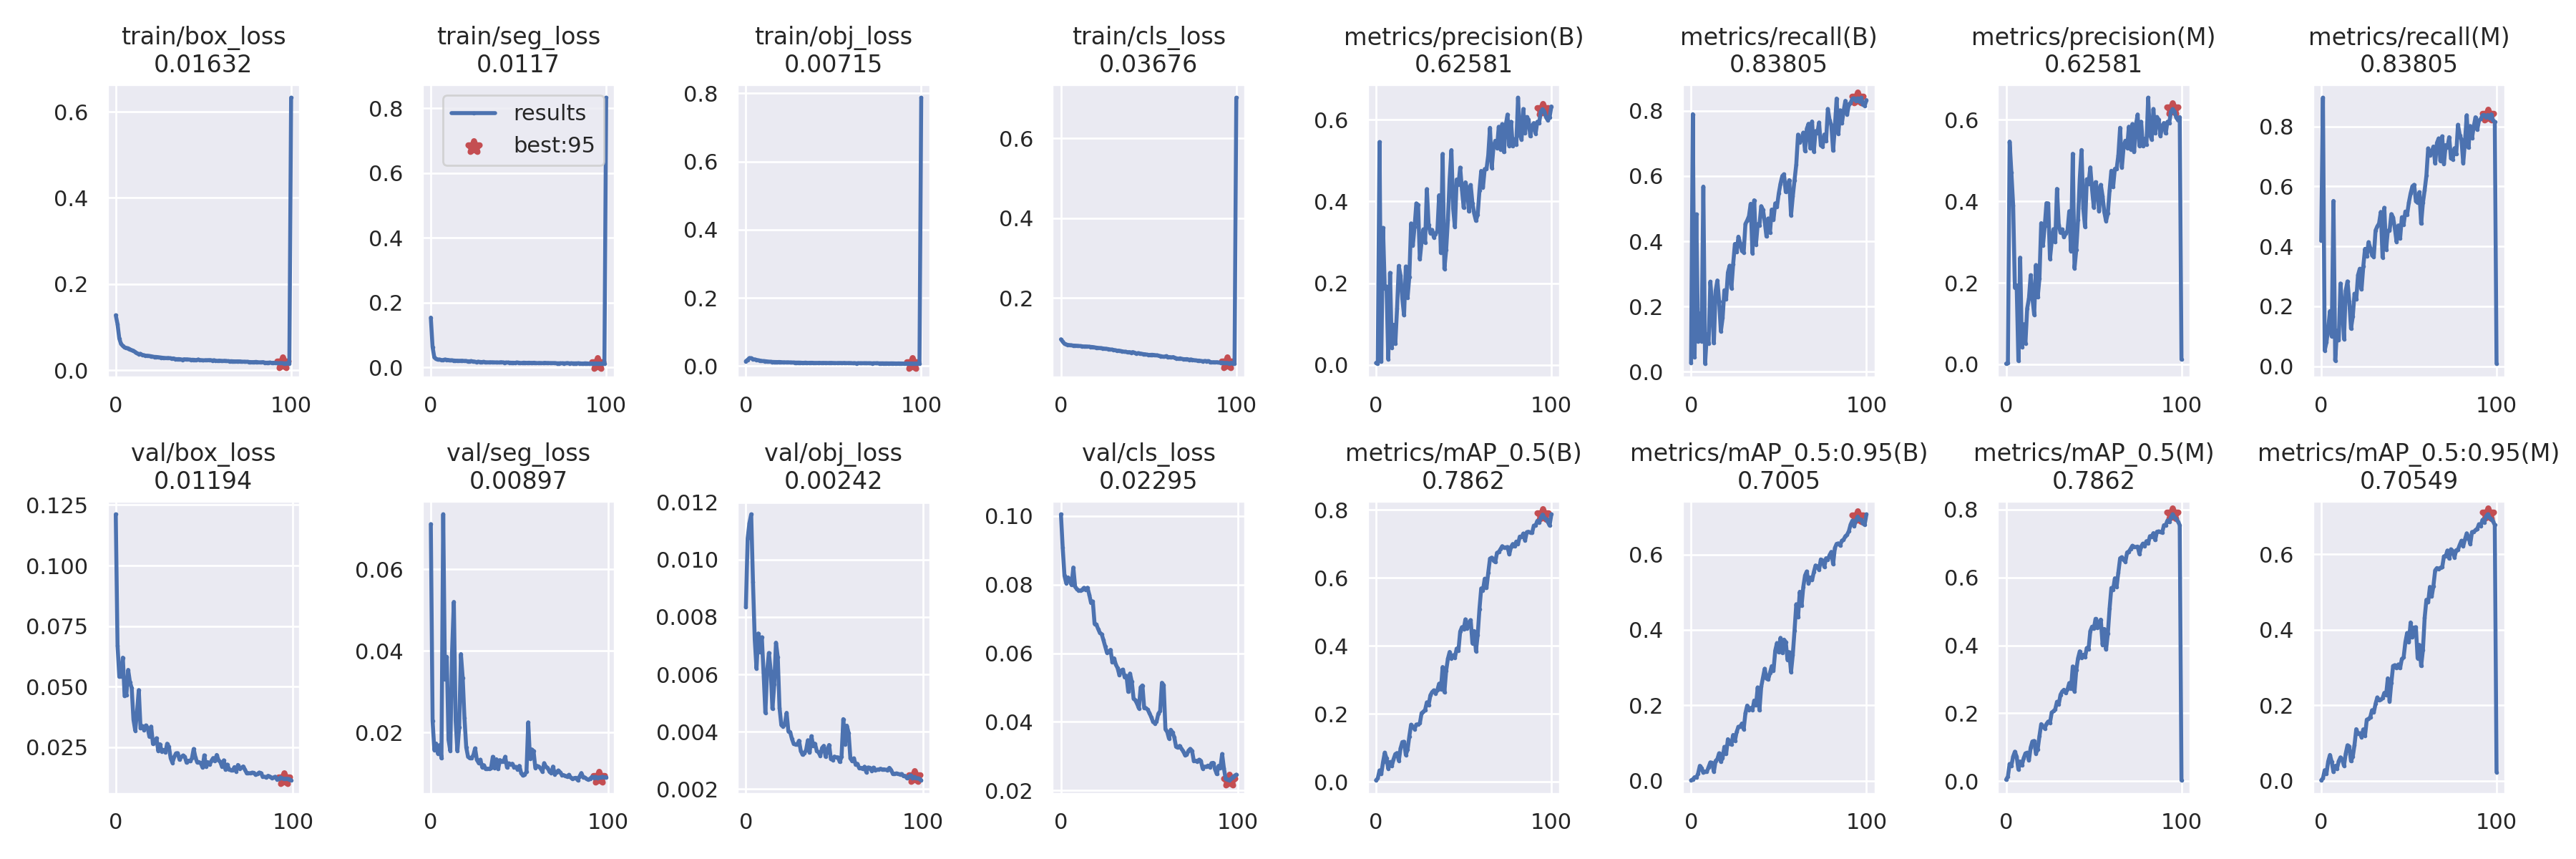

In [ ]:
!python segment/train.py --img 320 --batch 128 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5s-seg.pt
display.Image(filename=f'runs/train-seg/exp/results.png', width=1200)

Above we see training plots for our custom trained model. This plot along with other detailed results and sample predictions are all automatically generated and stored in the `runs` folder. See `runs/train-seg/exp`.

### Validate Your Custom Model

Repeat step 2 from above to test and validate your custom model.

In [ ]:
!python segment/val.py --weights runs/train-seg/exp/weights/best.pt --data {dataset.location}/data.yaml --img 320

segment/val: data=/content/yolov5/ASL-Poly-Instance-Seg-24/data.yaml, weights=['runs/train-seg/exp/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 165 layers, 7465847 parameters, 0 gradients, 25.9 GFLOPs
val: Scanning '/content/yolov5/ASL-Poly-Instance-Seg-24/valid/labels.cache' images and labels... 334 found, 0 missing, 0 empty, 0 corrupt: 100% 334/334 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 11/11 [00:07<00:00,  1.46it/s]
                   all        334        334      0.632      0.

### Infer With Your Custom Model

segment/predict: weights=['runs/train-seg/exp/weights/best.pt'], source=/content/yolov5/ASL-Poly-Instance-Seg-24/test/images/M9_jpg.rf.ce76f48ea6838e50917f1c81ff0ff208.jpg, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 165 layers, 7465847 parameters, 0 gradients, 25.9 GFLOPs
image 1/1 /content/yolov5/ASL-Poly-Instance-Seg-24/test/images/M9_jpg.rf.ce76f48ea6838e50917f1c81ff0ff208.jpg: 320x320 1 M, 6.9ms
Speed: 0.3ms pre-process, 6.9ms inference, 1.2ms NMS per image at shape (1, 3, 320, 32

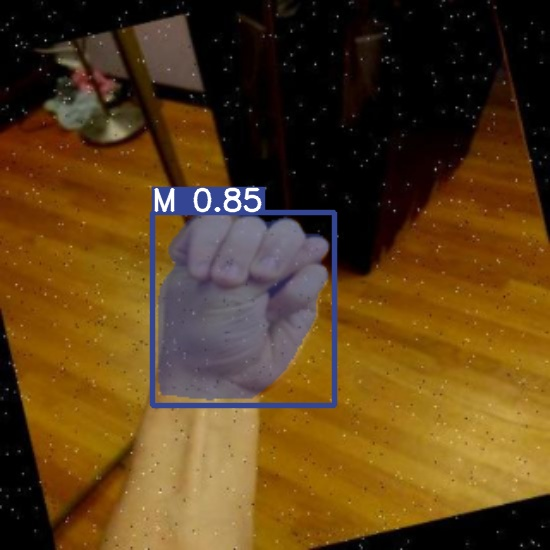

In [ ]:
import os
#Get the path of an image from the test or validation set
if os.path.exists(os.path.join(dataset.location, "test")):
  split_path = os.path.join(dataset.location, "test", "images")
else:
  split_path = os.path.join(dataset.location, "valid", "images")
example_image_name = os.listdir(split_path)[0]
example_image_path = os.path.join(split_path, example_image_name)

#Infer
!python segment/predict.py --img 320 --weights runs/train-seg/exp/weights/best.pt --source {example_image_path}
display.Image(filename=f'runs/predict-seg/exp2/{example_image_name}', width=600)

The image above shows the resulting prediction overlayed on the input image.

## (OPTIONAL) Improve Our Model with Active Learning

Now that we've trained our model once, we will want to continue to improve its performance. Improvement is largely dependent on improving our dataset.

We can programmatically upload example failure images back to our custom dataset based on conditions (like seeing an underrpresented class or a low confidence score) using the same `pip` package.

In [ ]:
#Prepare Our Example Image Directory
#To run on your own images, replace the directory on the line below with a 
#directory you provide (by uploading to the colab environment, for example)
example_image_dir = "../example_images"

#We are going to download example images from the web for the purposes of this
#demo. These images are relevant to the ASL Poly dataset. Skip the rest of this
#cell if you are providing your own example image directory.
os.makedirs(example_image_dir, exist_ok=True)
image_links = [
    "https://i.imgur.com/rFsDnHC.jpg", 
    "https://i.imgur.com/aEcceXm.jpg", 
    "https://i.imgur.com/s4N63fx.jpg",
    ]

for i,link in enumerate(image_links):
  img_data = requests.get(link).content
  with open(os.path.join(example_image_dir,f'example_{i}.jpg'), 'wb') as handler:
    handler.write(img_data)

In [ ]:
#Infer On Directory
!python segment/predict.py --img 320 --weights runs/train-seg/exp/weights/best.pt --source {example_image_dir} --save-txt --save-conf

segment/predict: weights=['runs/train-seg/exp/weights/best.pt'], source=../example_images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 165 layers, 7465847 parameters, 0 gradients, 25.9 GFLOPs
image 1/3 /content/example_images/example_0.jpg: 320x320 1 L, 1 Y, 8.2ms
image 2/3 /content/example_images/example_1.jpg: 320x320 1 G, 1 I, 8.7ms
image 3/3 /content/example_images/example_2.jpg: 320x320 1 H, 6.9ms
Speed: 0.3ms pre-process, 8.0ms inference, 1.0ms NMS per image at shape (1, 3, 320, 32

In [ ]:
#Read Results Files and Conditionally Upload

#If my model has a confidence of less than 80% for a prediction, let's help it
#out by uploading this image back to our dataset. Then we can add a ground truth
#label to it so that it will be included in our next training run and future 
#prediction results will improve.
MIN_CONF_THRESHOLD = 0.8 

for i,txt_file in enumerate(os.listdir("runs/predict-seg/exp3/labels")):
  with open(os.path.join("runs/predict-seg/exp3/labels",txt_file), 'r') as fid:
    for line in fid:
      label, x1, y1, x2, y2, conf = line.split(" ")
      conf = float(conf)
      if conf < MIN_CONF_THRESHOLD:
        print(f"Image has a low confidence prediction, uploading to project: example_{i}.jpg")
        #Upload via Roboflow pip package
        project.upload(os.path.join(example_image_dir,f'example_{i}.jpg'))
        break

Image has a low confidence prediction, uploading to project: example_0.jpg
Image has a low confidence prediction, uploading to project: example_1.jpg
Image has a low confidence prediction, uploading to project: example_2.jpg
